In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,10)
# plt.style.use('fivethirtyeight')
from datetime import timedelta
from keras.models import *
from keras.layers import *
from sklearn.preprocessing import *
import seaborn as sns

In [2]:
# Load Dataset
data = pd.read_csv('HUElec.csv')
HUElec = pd.melt(data, id_vars=["Date"], var_name='time')
HUElec['time'] = pd.to_timedelta(HUElec['time'].apply(lambda t: f"{t[:5]}:00")) - timedelta(minutes=30)
HUElec['Date'] = pd.to_datetime(HUElec['Date'], format="%m/%d/%Y")
HUElec['Datetime'] = HUElec['Date'] + HUElec['time']
HUElec = HUElec.set_index('Datetime')
HUElec = HUElec.drop(['Date', 'time'], axis=1).sort_index()

# View formatted data
HUElec.head()

,value
Datetime,
2010-01-25 00:00:00,0.0
2010-01-25 00:30:00,0.0
2010-01-25 01:00:00,0.0
2010-01-25 01:30:00,0.0
2010-01-25 02:00:00,0.0


In [3]:
data = HUElec.copy()

df = data.resample(rule='H').sum()

df.index

DatetimeIndex(['2010-01-25 00:00:00', '2010-01-25 01:00:00',
               '2010-01-25 02:00:00', '2010-01-25 03:00:00',
               '2010-01-25 04:00:00', '2010-01-25 05:00:00',
               '2010-01-25 06:00:00', '2010-01-25 07:00:00',
               '2010-01-25 08:00:00', '2010-01-25 09:00:00',
               ...
               '2022-03-01 14:00:00', '2022-03-01 15:00:00',
               '2022-03-01 16:00:00', '2022-03-01 17:00:00',
               '2022-03-01 18:00:00', '2022-03-01 19:00:00',
               '2022-03-01 20:00:00', '2022-03-01 21:00:00',
               '2022-03-01 22:00:00', '2022-03-01 23:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=106056, freq='H')

In [4]:
df['Hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek
df['day_of_month'] = df.index.day
df['month'] = df.index.month

In [5]:
df.head()

,value,Hour,day_of_week,day_of_month,month
Datetime,,,,,
2010-01-25 00:00:00,0.0,0,0,25,1
2010-01-25 01:00:00,0.0,1,0,25,1
2010-01-25 02:00:00,0.0,2,0,25,1
2010-01-25 03:00:00,0.0,3,0,25,1
2010-01-25 04:00:00,0.0,4,0,25,1


<AxesSubplot:xlabel='Datetime', ylabel='value'>

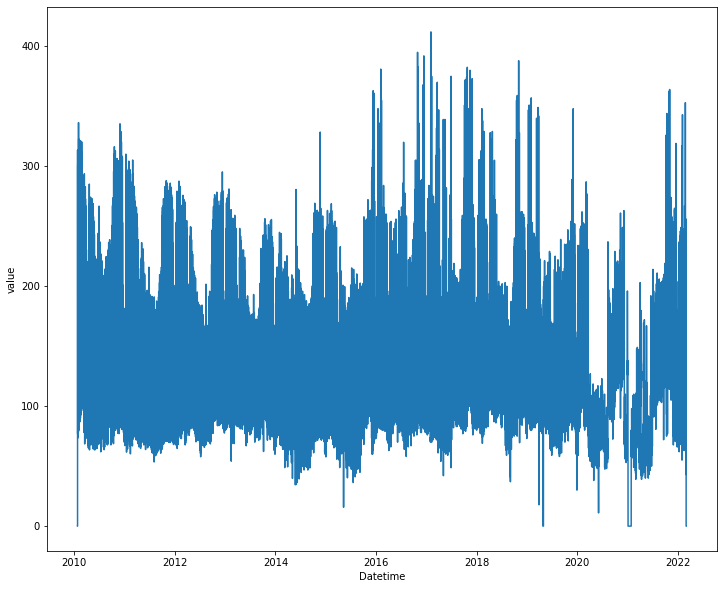

In [6]:
sns.lineplot(x=df.index, y='value', data=df)

<AxesSubplot:xlabel='Datetime', ylabel='value'>

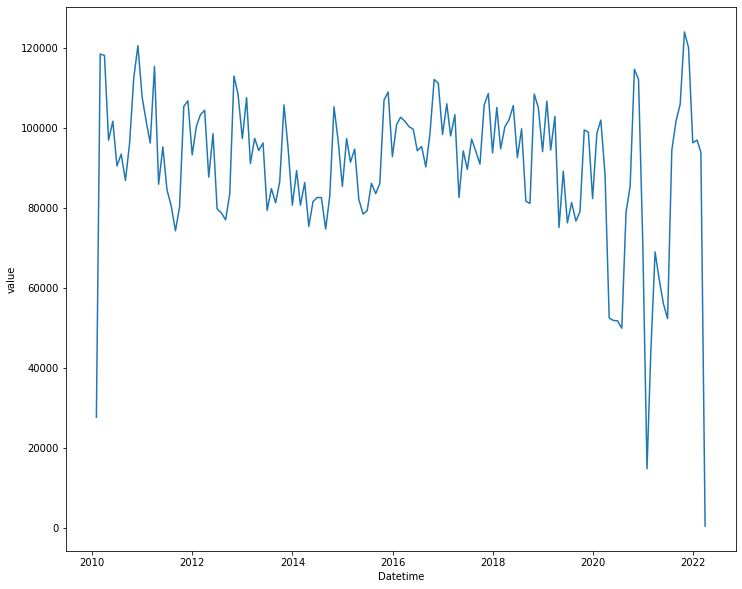

In [7]:
df_by_month = df.resample(rule='M').sum()

sns.lineplot(x=df_by_month.index, y='value', data=df_by_month)

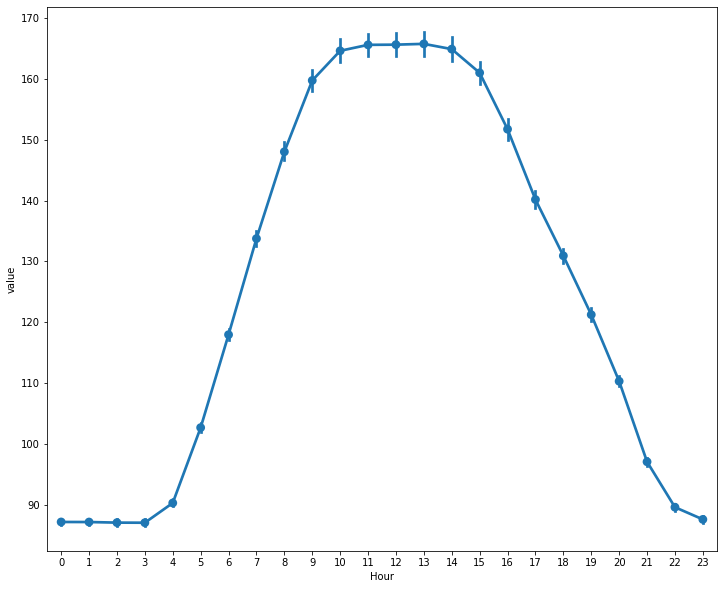

In [8]:
sns.pointplot(data=df, x='Hour', y='value');

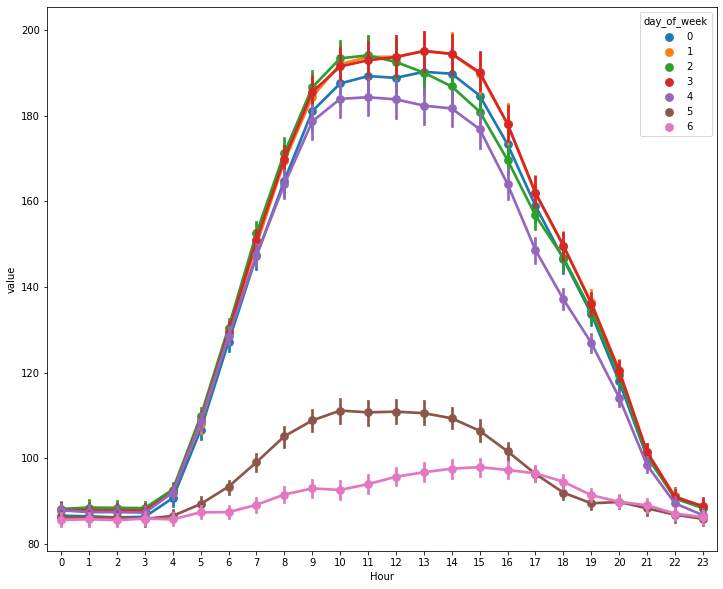

In [9]:
sns.pointplot(data=df, x='Hour', y='value', hue='day_of_week');

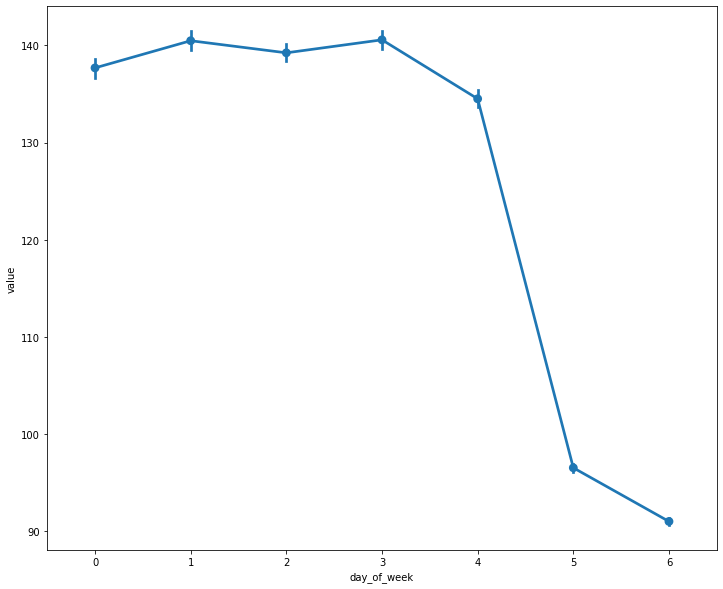

In [10]:
sns.pointplot(data=df, x='day_of_week', y='value');

In [11]:
# Splitting the data
train_size = int(len(df) * 0.9)
test_size = len(df) - train_size

train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]

print(train.shape, test.shape)

(95450, 5) (10606, 5)


In [ ]:
f_columns = ['Hour', 'day_of_week', 'day_of_month', 'month']

f_transformer = RobustScaler()
value_transformer = RobustScaler()

f_transformer = f_transformer.fit(train[f_columns].to_numpy())
value_transformer = value_transformer.fit(train[['value']])

train.loc[:,f_columns] = f_transformer.transform(train[f_columns].to_numpy())
train['value'] = value_transformer.transform(train[['value']])

test.loc[:,f_columns] = f_transformer.transform(test[f_columns].to_numpy())
test['value'] = value_transformer.transform(test[['value']])

In [13]:
def create_dataset(X, y, time_step=1):
    Xs, ys = [], []

    for i in range(len(X) - time_step):
        v = X.iloc[i:(i+time_step)].to_numpy()
        Xs.append(v)
        ys.append(y.iloc[i+time_step])

    return np.array(Xs), np.array(ys)

In [14]:
TIME_STEPS = 24 # Taking 24 hour time steps to predict the next hour

X_train, y_train = create_dataset(train, train.value, time_step=TIME_STEPS)
X_test, y_test = create_dataset(test, test.value, time_step=TIME_STEPS)

In [15]:
# create_dataset converts the data to this format [samples, time_steps, n_features]

print(X_train.shape, y_train.shape)

(95426, 24, 5) (95426,)


In [16]:
print(X_test.shape, y_test.shape)

(10582, 24, 5) (10582,)


In [17]:
X_train[0][0].shape

(5,)

In [18]:
model = Sequential()
model.add(Bidirectional(LSTM(units=128, input_shape=(X_train.shape[1], X_train.shape[2]))))
model.add(Dropout(rate=0.2))
model.add(Dense(units=1))

In [19]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [20]:
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.1, shuffle=False)

Epoch 1/30
2684/2684 [==============================] - 73s 19ms/step - loss: 0.0743 - val_loss: 0.0353
Epoch 2/30
2684/2684 [==============================] - 50s 19ms/step - loss: 0.0180 - val_loss: 0.0290
Epoch 3/30
2684/2684 [==============================] - 53s 20ms/step - loss: 0.0157 - val_loss: 0.0258
Epoch 4/30
2684/2684 [==============================] - 60s 23ms/step - loss: 0.0142 - val_loss: 0.0233
Epoch 5/30
2684/2684 [==============================] - 62s 23ms/step - loss: 0.0135 - val_loss: 0.0224
Epoch 6/30
2684/2684 [==============================] - 62s 23ms/step - loss: 0.0130 - val_loss: 0.0204
Epoch 7/30
2684/2684 [==============================] - 62s 23ms/step - loss: 0.0128 - val_loss: 0.0206
Epoch 8/30
2684/2684 [==============================] - 62s 23ms/step - loss: 0.0126 - val_loss: 0.0204
Epoch 9/30
2684/2684 [==============================] - 62s 23ms/step - loss: 0.0127 - val_loss: 0.0197
Epoch 10/30
2684/2684 [==============================] - 62s 23m

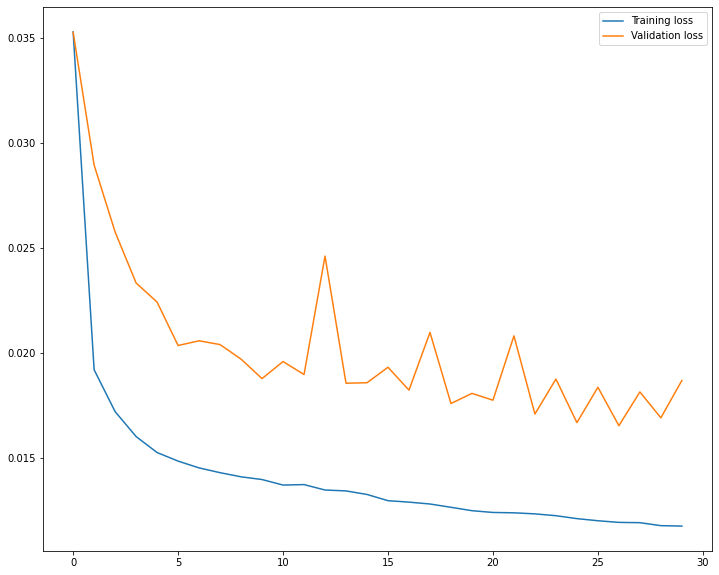

In [21]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend();

In [22]:
y_pred = model.predict(X_test)

In [23]:
y_train_inv = value_transformer.inverse_transform(y_train.reshape(1,-1))
y_test_inv = value_transformer.inverse_transform(y_test.reshape(1,-1))
y_pred_inv = value_transformer.inverse_transform(y_pred)

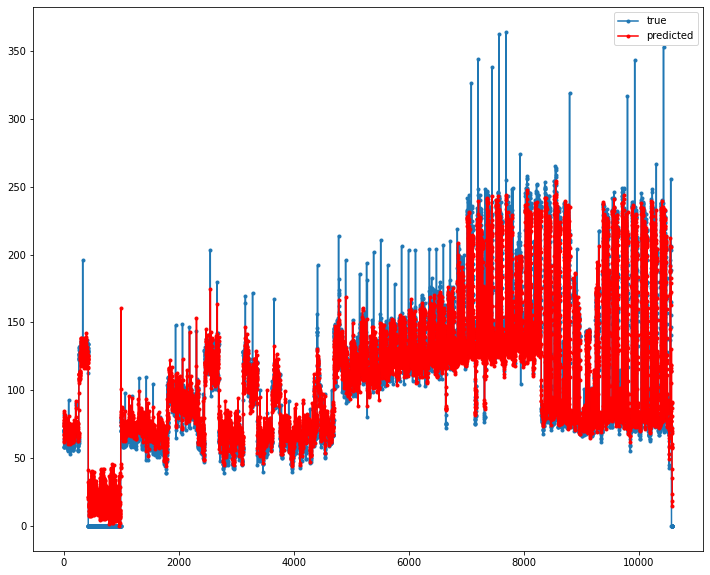

In [24]:
plt.plot(y_test_inv.flatten(), marker='.', label='true')
plt.plot(y_pred_inv.flatten(), marker='.', color='r', label='predicted')
plt.legend();

In [ ]:
n_future = 90 # Predicting the next 3 months from last data entry
forecast_period_dates = pd.date_range('2022-03-01', periods=n_future, freq='1d')

In [ ]:
forecast = model.predict(X_test[-n_future:])

In [ ]:
y_pred_future = value_transformer.inverse_transform(forecast)

In [ ]:
# Convert timestamp to date
forecast_dates = []
for time_i in forecast_period_dates:
    forecast_dates.append(time_i.date())

In [ ]:
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Open':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])

df_forecast.head()

In [ ]:
original = df[['Date', 'Open']]
original['Date']=pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2021-12-17']

original.head()